In [1]:
# SelfmadeTOD.py
# Gu Lee
# 2021.01.27
# v0.0.5
# 각 topic의 max, min 값을 붉은색 dashed line으로 표시.
# Override feedback, Gear position plot
# Switch: Auto Standby Switch --> Override Feedback

import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
import numpy as np
import csv
from datetime import datetime
import time
import math
import os
import os.path
import glob

Python older than 3.7 detected. 


In [15]:
class Data:
    def __init__(self):
        self.average_speed = 0
        self.auto_driving_times = []
        self.manual_driving_times = []
        self.total_auto_driving_time = 0
        self.total_manual_driving_time = 0
        self.auto_driving_distances = []
        self.manual_driving_distances = []
        self.total_auto_driving_distance = 0
        self.total_manual_driving_distance = 0
        self.auto_time_record = []
        self.manual_time_record = []
        
    def __info__(self):
        print("Data Structure for Pre-driving report")
        return
    
    def __repr__(self):
        result = "Ioniq Info Analysis"
        result += ("\naverage_speed: " + str(round(self.average_speed,2)))
        result += ("\ntotal_auto_driving_time: " + str(round(self.total_auto_driving_time,2)))
        result += ("\ntotal_auto_driving_distance: " + str(round(self.total_auto_driving_distance,2)))
        result += ("\ntotal_manual_driving_distance: " + str(round(self.total_manual_driving_distance,2)))
        return result

class BagParser:
    def __init__(self,bagfile_name, selected_info = ["Average Speed", "Steering Angle", "Auto Standby Switch",
                                                     "BPS Feedback", "APS Feedback", "Override Feedback",
                                                     "Gear Position"],
                 y_axis_names = ["Average Speed(km/h)", "Steering Angle(degree)", 
                                 "Auto Standby Switch", "BPS Feedback", "APS Feedback", 
                                 "Override Feedback", "Gear Position"],
                 y_lims = [[0, 120], [-600,600], [0,2], [0,300], [0,300], [0,7], [0, 10]],
                 y_max = [[None],[-540, 540], [None], [255], [255], [None], [None]],
                 save = True):
        self.save = save
        self.bagfile_name = bagfile_name
        self.bagreader = bagreader(bagfile_name+'.bag')
        self.selected_info = selected_info # ex) ["Average Speed", "Steering Angle"]
        self.y_axis_names = y_axis_names
        self.y_lims = y_lims
        self.start_time = self.bagreader.start_time
        self.change_point_idx = []
        self.resultData = Data()
        self.y_max = y_max
        self.get_data()
        
    def summary(self):
        return self.bagreader.topic_table
    
    def rostime2datetime(self, rostime):
        time2 = time.localtime(rostime)
        real_rostime = round(rostime) 
        y = time2.tm_year 
        m = time2.tm_mon
        d = time2.tm_mday
        t_h = time2.tm_hour
        t_m = time2.tm_min
        t_s = time2.tm_sec
        t_ms = str(round(rostime - real_rostime,4)).split(".")
        t_ms = t_ms[-1] 
        return str(y)+"-"+str(m)+"-"+str(d)+" "+str(t_h)+":"+str(t_m)+":"+str(t_s)+":"+str(t_ms)
    
    def get_data(self, GPS = False, SCC = False):
        self.data = []
        try:
            data = self.bagreader.message_by_topic('/Ioniq_info')
            print("File saved: {}".format(data))  
        except:
            pass

        if GPS:
            try:
                data = self.bagreader.message_by_topic('/utm_fix')
                print("File saved: {}".format(data))  
            except:
                print("There are no GPS info")
                pass
        
        if SCC:
            try:
                data = self.bagreader.message_by_topic('/scc/closist_distance')
                print("File saved: {}".format(data))  
            except:
                print("There are no SCC info")
                pass
        
        data = pd.read_csv("./"+bagfile_name+"/Ioniq_info.csv")
        
        data.rename(columns={'data_0':'APS ACT Feedback','data_1':'Brake ACT Feedback', 'data_2':'Gear Position', 
                             'data_3':'Steering Angle', 'data_4':'ESTOP Switch', 'data_5':'Auto Standby Switch', 
                             'data_6':'APM Switch', 'data_7':'ASM Switch', 'data_8':'AGM Switch', 'data_9':'Override Feedback',
                             'data_10':'Turn Signal', 'data_11':'BPS Feedback', 'data_12':'APS Feedback', 'data_13':'Driver Belt',
                             'data_14':'Trunk','data_15':'DoorFL', 'data_16':'DoorFR', 'data_17':'DoorRL', 'data_18':'DoorRR', 
                             'data_19':'Average Speed','data_20':'Wheel FL', 'data_21':'WheelFR', 'data_22':'WheelRL',
                             'data_23':'WheelRR'}, inplace=True)
        
        if GPS:
            utm = pd.read_csv("/home/artiv/SMDTG_SCC" + bagfile_name+ "/utm_fix.csv")
            utm.rename(columns={'pose.position.x':'utm_x', 'pose.position.y':'utm_y'}, inplace=True)
        
            self.utm_x = utm['utm_x']
            self.utm_y = utm['utm_y']

        if SCC:
            scc = pd.read_csv("./" + bagfile_name+ "/scc-closist_distance.csv")
            scc.rename(columns={'data_1':'distance'}, inplace=True)
            self.scc_time = scc['Time']
            self.scc_distance = scc['distance']
            self.scc_relTime = []
            for i in range(len(self.scc_time)):
                temp = self.scc_time[i] - self.scc_time[0]
                temp = round(temp, 7)
                self.scc_relTime.append(temp)

            
        self.all_data = data
        self.override_feedback = data['Override Feedback']
        
        self.rosTime = list(data['Time'])
        self.relativeTime = []

        for i in self.rosTime:
            rel_time = i - self.start_time
            rel_time = round(rel_time, 7)
            self.relativeTime.append(rel_time)
            
        for i in range(len(self.selected_info)):
            self.data.append(data[self.selected_info[i]])
        
        print("Preprocessing is Successfully Done!!!!!")
    
    def override_feedback_to_switch_data(self):
        result = []
        for i in range(len(self.override_feedback)):
            if self.override_feedback[i] == 1:
                result.append(1)
            else:
                result.append(0)
        return result
    
    def switch_idx_parser(self):
        # get change_poind_idx list
        # self.switch_data = self.data[2]
        self.switch_data = self.override_feedback_to_switch_data()
        for i in range(len(self.switch_data)-1):
            current = self.switch_data[i]
            next = self.switch_data[i+1]
            if current == next:
                continue
            else:
                #print("current, next", current, next)
                self.change_point_idx.append(i+1)
        self.change_point_idx.insert(0, 0)
        self.change_point_idx.append(len(self.switch_data)-1)
        #print(self.change_point_idx)
        
    def calc_distance_info(self, start_idx, end_idx):
        """
        Params
        start_idx: Time index from when the drive started
        end_idx: Time index from when the drive ended
        
        Return
        Total mileage in meters      
        """
        self.vel_data = self.all_data["Average Speed"]
        total_distance = 0
        for i in range(start_idx, end_idx):
            d_time = round(self.relativeTime[i+1]-self.relativeTime[i], 5)
            temp = self.vel_data[i] / 3.6 * d_time
            #print(d_time, ", ",temp)
            temp = round(temp, 3)
            total_distance += temp
        return total_distance
        
    def calc_aver_vel(self, start_idx, end_idx):
        return np.mean(np.array(self.vel_data[start_idx:end_idx]))
    
    def calc_full_info(self):
        self.switch_idx_parser()
        for i in range(len(self.change_point_idx)-1):
            start_idx = self.change_point_idx[i]
            end_idx = self.change_point_idx[i+1]

            start_time = self.relativeTime[start_idx]
            end_time = self.relativeTime[end_idx-1]

            drivingTime = end_time - start_time
            mileage = self.calc_distance_info(start_idx, end_idx)
                
            if int(self.switch_data[start_idx]) == 0:
                #manual
                self.resultData.manual_driving_times.append(drivingTime)
                self.resultData.manual_driving_distances.append(mileage)
                self.resultData.manual_time_record.append([start_time, end_time])
                
            else:
                #auto
                self.resultData.auto_driving_times.append(drivingTime)
                self.resultData.auto_driving_distances.append(mileage)
                self.resultData.auto_time_record.append([start_time, end_time])
                
        self.resultData.average_speed = np.mean(np.array(self.vel_data))
        self.resultData.total_auto_driving_distance = sum(self.resultData.auto_driving_distances)
        self.resultData.total_manual_driving_distance = sum(self.resultData.manual_driving_distances)
        self.resultData.total_auto_driving_time = sum(self.resultData.auto_driving_times)
        self.resultData.total_manual_driving_time = sum(self.resultData.manual_driving_times)
        print("Calcultation Full Info Done!!!")
        if self.save:
            self.save_full_info()
        return
    
    def save_full_info(self):
        with open(self.bagfile_name+".txt", "w") as f:
            
            f.write("Ioniq Info Analysis")
            f.write("\n========================= summary =========================")

            f.write("\nBagfile name: " + self.bagfile_name)
            start_time = self.rostime2datetime(self.start_time)
            f.write("\nStart time: " + start_time+"(KST)")
            end_time = self.rostime2datetime(self.rosTime[-1])
            f.write("\nEnd time: " + end_time+"(KST)")

            f.write("\ntotal average_speed: " + str(round(self.resultData.average_speed,2))+"(Km/h)") # total average speed
            f.write("\ntotal auto driving time: " + str(round(self.resultData.total_auto_driving_time,2))+"(s)")
            f.write("\ntotal manual driving time: " + str(round(self.resultData.total_manual_driving_time,2))+"(s)")
            f.write("\ntotal auto driving distance: " + str(round(self.resultData.total_auto_driving_distance,2))+"(m)")
            f.write("\ntotal manual driving distance: " + str(round(self.resultData.total_manual_driving_distance,2))+"(m)")
            f.write("\n===========================================================\n")
            
            for i in range(len(self.change_point_idx)-1):
                start_idx = self.change_point_idx[i]
                end_idx = self.change_point_idx[i+1]
                f.write("\n-------------- Section " + str(i+1) + " --------------")
                if int(self.switch_data[start_idx]) == 0:
                    mode = "Manual"
                else:
                    mode = "Auto"
                f.write("\nAuto/Manual: " + mode)
                aver_vel = self.calc_aver_vel(start_idx,end_idx)
                f.write("\nDuration: "+str(round(self.relativeTime[start_idx],2))+" ~ "+str(round(self.relativeTime[end_idx],2)))
                f.write("\nAverage Velocity: " + str(round(aver_vel,2)))
                distance = self.calc_distance_info(start_idx, end_idx)
                f.write("\nDriving Distance: "+ str(round(distance, 2))+"(m)")
                f.write("\n----------------------------------------\n")
                
    def visualize(self, GPS = False, SCC=False):
        fig = plt.figure(figsize=(10,20))
        plt.rcParams['axes.grid'] = True 
        #plt.rcParams["figure.figsize"] = (300,3000) 
        print("total number  of graph: ", len(self.selected_info))
        for i in range(len(self.selected_info)):
            x = self.relativeTime 
            y = self.data[i]
            ax = fig.add_subplot(len(self.selected_info)+1, 1, i+1)
            ax.set_xlabel("time(s)")
            ax.set_title(self.y_axis_names[i])
            ax.set_ylim(self.y_lims[i])

            max_list = self.y_max[i]
            max = []
            for i in range(len(max_list)):
                if max_list[i] != None:
                    ax.hlines(max_list[i], self.relativeTime[0], self.relativeTime[-1], color='red', linestyles='dashed')

            for i in range(len(self.change_point_idx)-1):
                start_idx = self.change_point_idx[i]
                end_idx = self.change_point_idx[i+1]
                if int(self.switch_data[start_idx]) == 1:
                    color = 'm'
                else:
                    color = 'c'
                plt.axvspan(self.relativeTime[start_idx], self.relativeTime[end_idx], facecolor = color, alpha=0.3)
            
            ax.plot(x,y)
        
        if SCC:   
            x = self.scc_relTime
            y = self.scc_distance
            
            ax = fig.add_subplot(len(self.selected_info)+1, 1, len(self.selected_info)+1)
            ax.set_xlabel("time(s)")
            ax.set_title("closest distance")
            ax.set_ylim([0, 100])
            
            for i in range(len(self.change_point_idx)-1):
                start_idx = self.change_point_idx[i]
                end_idx = self.change_point_idx[i+1]
                if int(self.data[2][start_idx]) == 0:
                    color = 'c'
                else:
                    color = 'm'
                plt.axvspan(self.relativeTime[start_idx], self.relativeTime[end_idx], facecolor = color, alpha=0.3)

        ax.plot(x,y)
        
        #plt.suptitle('Ioniq Info Analysis from '+self.bagfile_name, fontsize=20, y=0.92)
        plt.suptitle('Ioniq Info Analysis from '+self.bagfile_name, fontsize=10)
        #plt.subplots(constrained_layout = True)
        
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
        if self.save:
            plt.savefig(self.bagfile_name+'.png',dpi=800)
        #plt.autoscale()
        plt.show()
        plt.close
        
        if GPS:
            x = self.utm_x
            y = self.utm_y
            plt.scatter(x, y)
            plt.title('Ioniq Info Analysis from '+self.bagfile_name, fontsize=10, y=1.0)
            if self.save:
                plt.savefig(self.bagfile_name+'_gps.png',dpi=800)
            plt.show()
            plt.close()

/home/artiv/SMDTG_test/2021-02-17-18-20-57.bag
[INFO]  Data folder /home/artiv/SMDTG_test/2021-02-17-18-20-57 already exists. Not creating.
File saved: /home/artiv/SMDTG_test/2021-02-17-18-20-57/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
File saved: /home/artiv/SMDTG_test/2021-02-17-18-20-57/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
Calcultation Full Info Done!!!
total number  of graph:  7


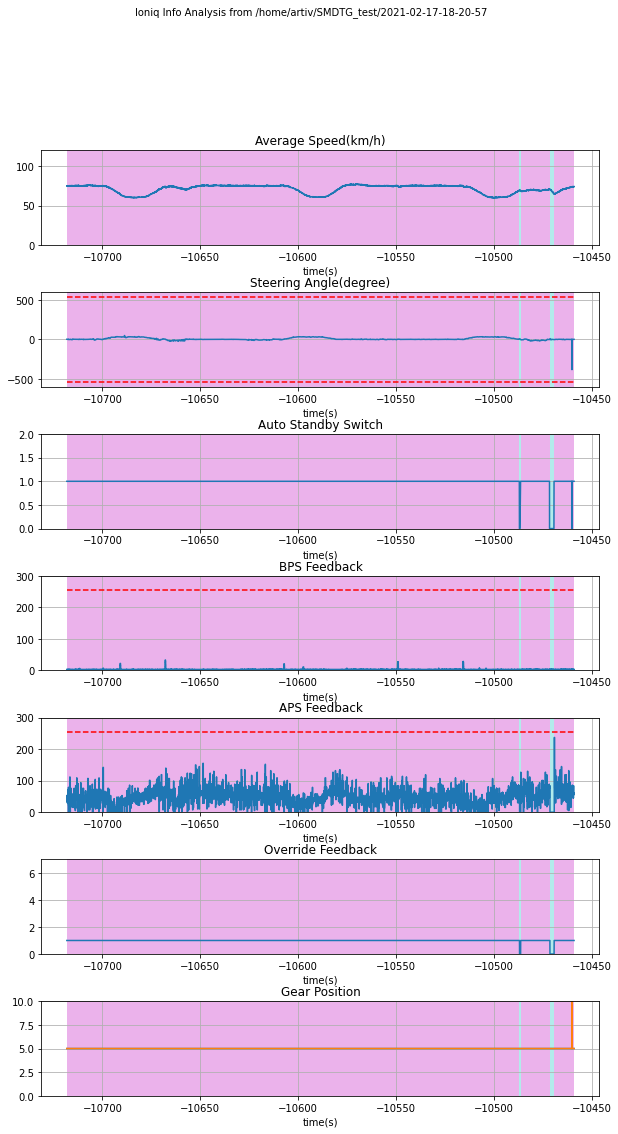

total:  5072.638999999986 m
manaul:  51.59000000000002 m
/home/artiv/SMDTG_test/2021-02-17-18-23-19.bag
[INFO]  Data folder /home/artiv/SMDTG_test/2021-02-17-18-23-19 already exists. Not creating.
File saved: /home/artiv/SMDTG_test/2021-02-17-18-23-19/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
File saved: /home/artiv/SMDTG_test/2021-02-17-18-23-19/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
Calcultation Full Info Done!!!
total number  of graph:  7


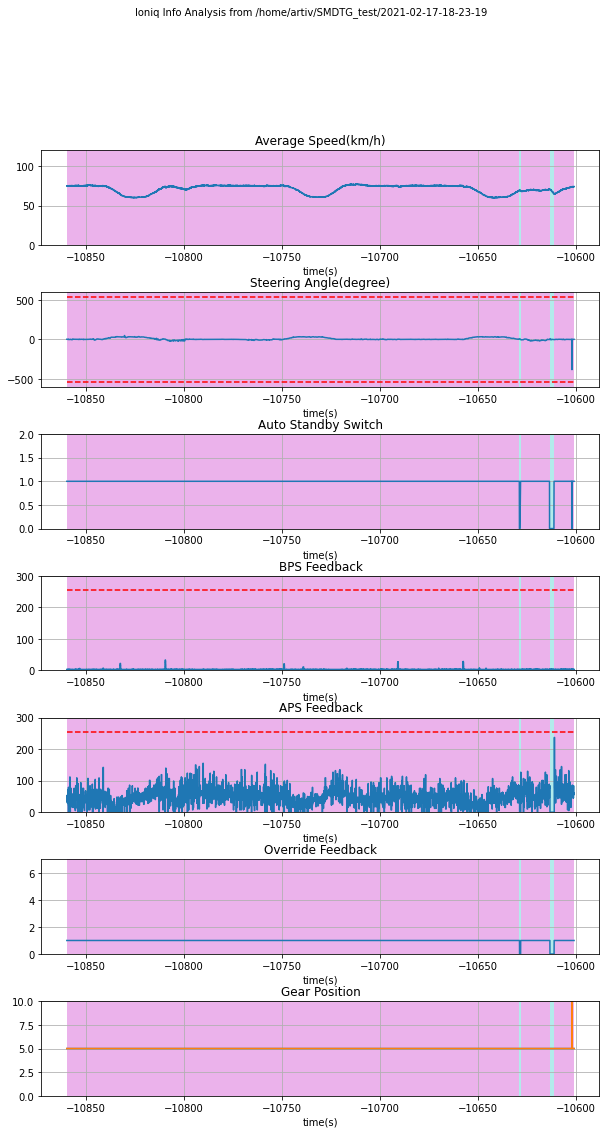

total:  5072.638999999986 m
manaul:  51.59000000000002 m
/home/artiv/SMDTG_test/2021-02-17-16-33-39.bag
[INFO]  Data folder /home/artiv/SMDTG_test/2021-02-17-16-33-39 already exists. Not creating.
File saved: /home/artiv/SMDTG_test/2021-02-17-16-33-39/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
File saved: /home/artiv/SMDTG_test/2021-02-17-16-33-39/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
Calcultation Full Info Done!!!
total number  of graph:  7


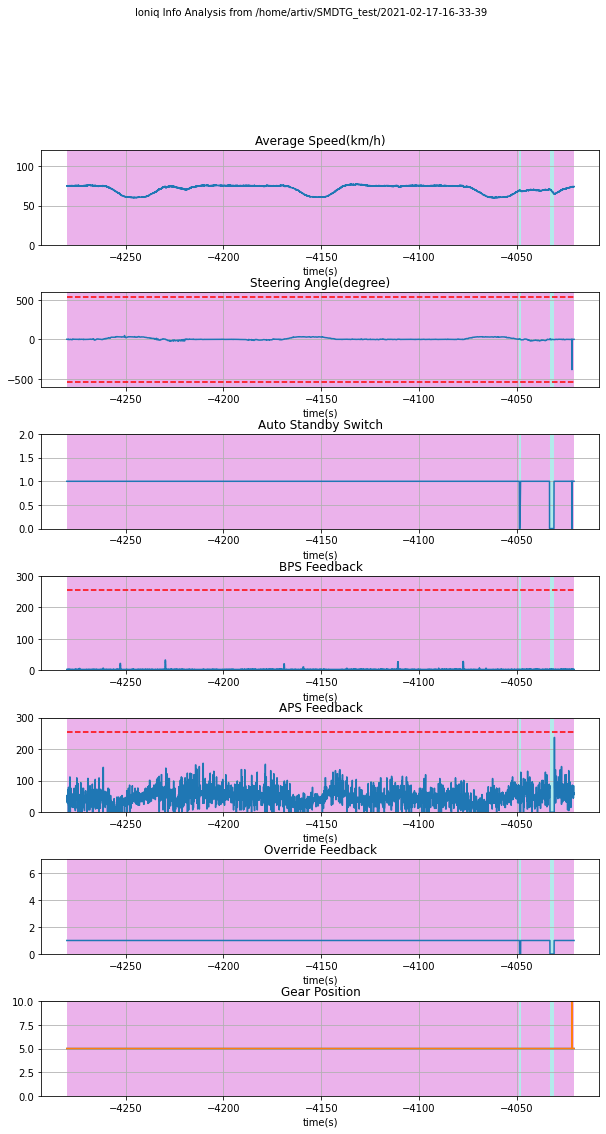

total:  5072.636999999985 m
manaul:  51.591000000000015 m
/home/artiv/SMDTG_test/2021-02-17-16-34-19.bag
[INFO]  Data folder /home/artiv/SMDTG_test/2021-02-17-16-34-19 already exists. Not creating.
File saved: /home/artiv/SMDTG_test/2021-02-17-16-34-19/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
File saved: /home/artiv/SMDTG_test/2021-02-17-16-34-19/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
Calcultation Full Info Done!!!
total number  of graph:  7


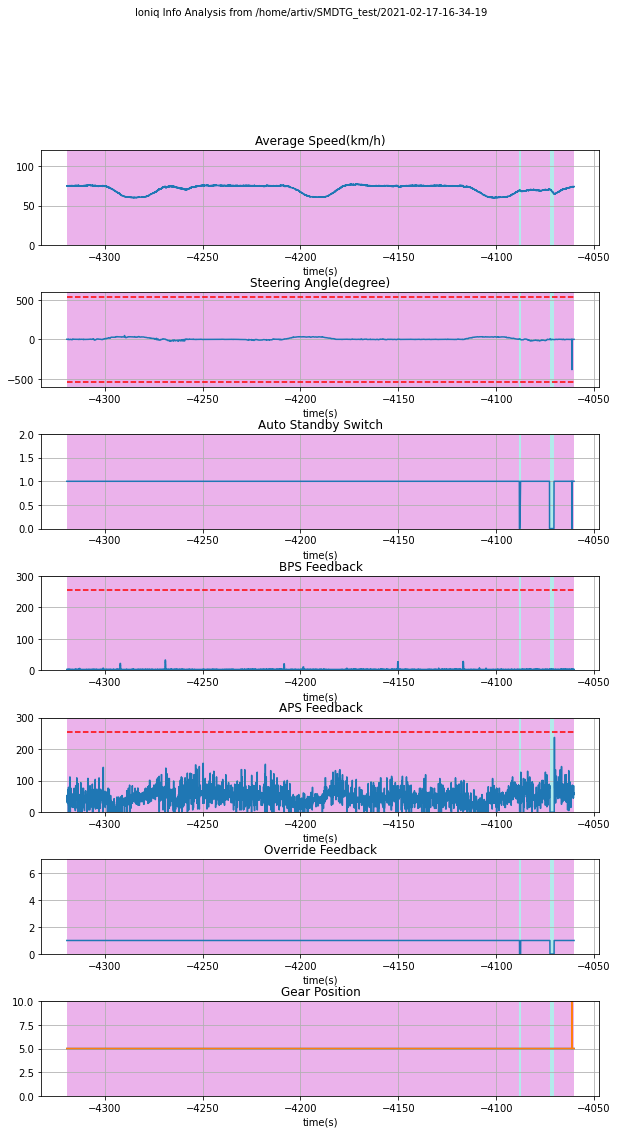

total:  5072.635999999985 m
manaul:  51.591000000000015 m
/home/artiv/SMDTG_test/2021-02-17-18-27-04.bag
[INFO]  Data folder /home/artiv/SMDTG_test/2021-02-17-18-27-04 already exists. Not creating.
File saved: /home/artiv/SMDTG_test/2021-02-17-18-27-04/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
File saved: /home/artiv/SMDTG_test/2021-02-17-18-27-04/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
Calcultation Full Info Done!!!
total number  of graph:  7


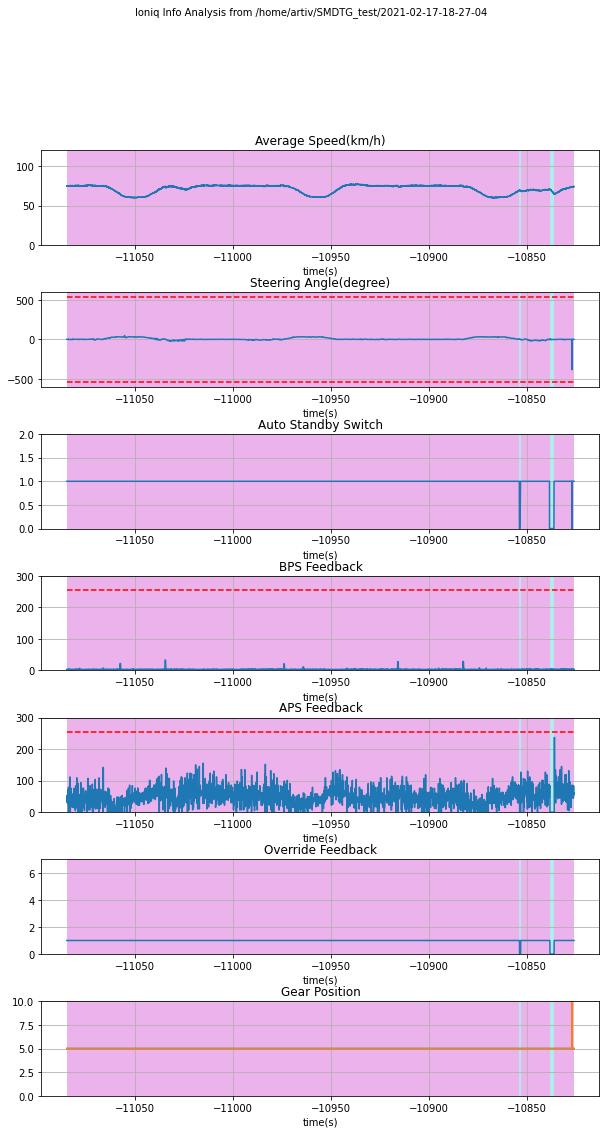

total:  5072.6339999999855 m
manaul:  51.59000000000002 m
/home/artiv/SMDTG_test/d/d/2021-02-17-15-33-56.bag
[INFO]  Data folder /home/artiv/SMDTG_test/d/d/2021-02-17-15-33-56 already exists. Not creating.
File saved: /home/artiv/SMDTG_test/d/d/2021-02-17-15-33-56/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
File saved: /home/artiv/SMDTG_test/d/d/2021-02-17-15-33-56/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
Calcultation Full Info Done!!!
total number  of graph:  7


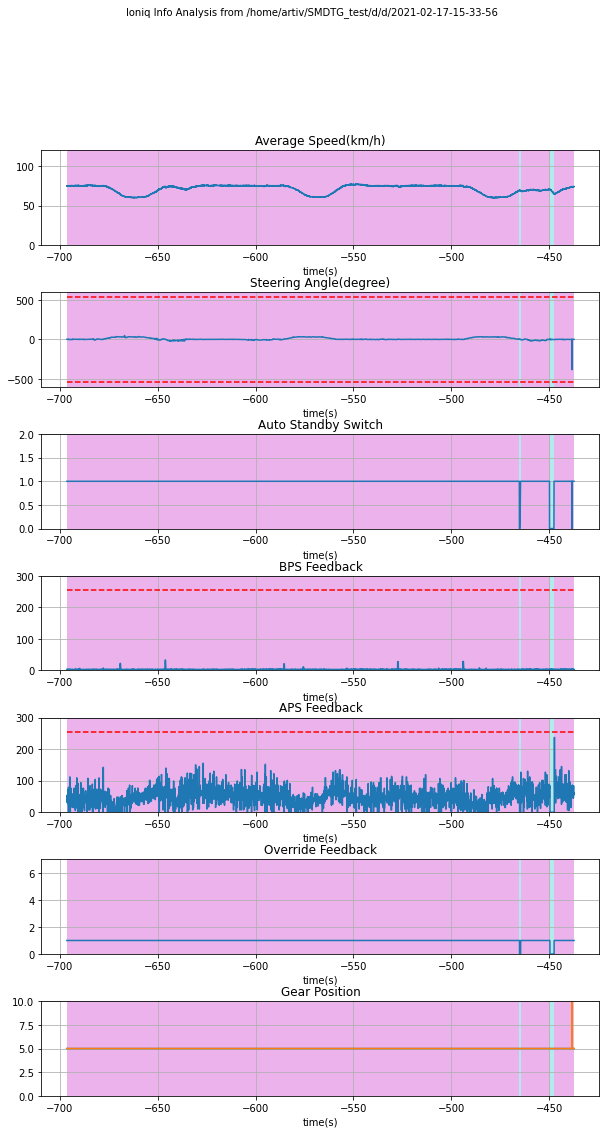

total:  5072.634999999986 m
manaul:  51.591000000000015 m
/home/artiv/SMDTG_test/d/d/2021-02-17-15-38-58.bag
[INFO]  Data folder /home/artiv/SMDTG_test/d/d/2021-02-17-15-38-58 already exists. Not creating.
File saved: /home/artiv/SMDTG_test/d/d/2021-02-17-15-38-58/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
File saved: /home/artiv/SMDTG_test/d/d/2021-02-17-15-38-58/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
Calcultation Full Info Done!!!
total number  of graph:  7


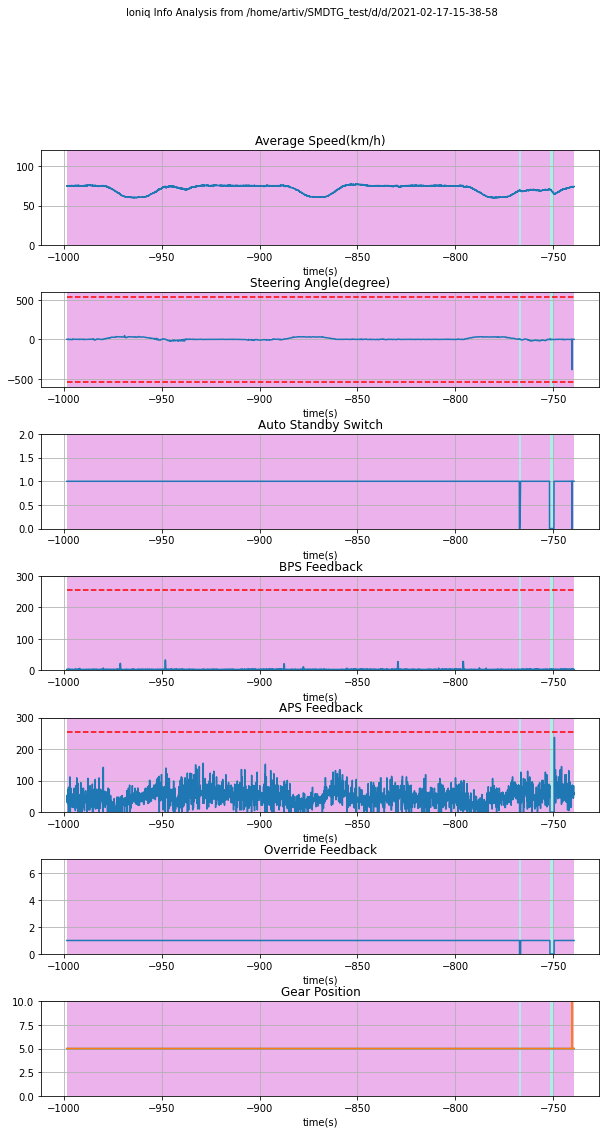

total:  5072.639999999986 m
manaul:  51.59000000000002 m
/home/artiv/SMDTG_test/d/d/2021-02-17-15-49-27.bag
[INFO]  Data folder /home/artiv/SMDTG_test/d/d/2021-02-17-15-49-27 already exists. Not creating.
File saved: /home/artiv/SMDTG_test/d/d/2021-02-17-15-49-27/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
File saved: /home/artiv/SMDTG_test/d/d/2021-02-17-15-49-27/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
Calcultation Full Info Done!!!
total number  of graph:  7


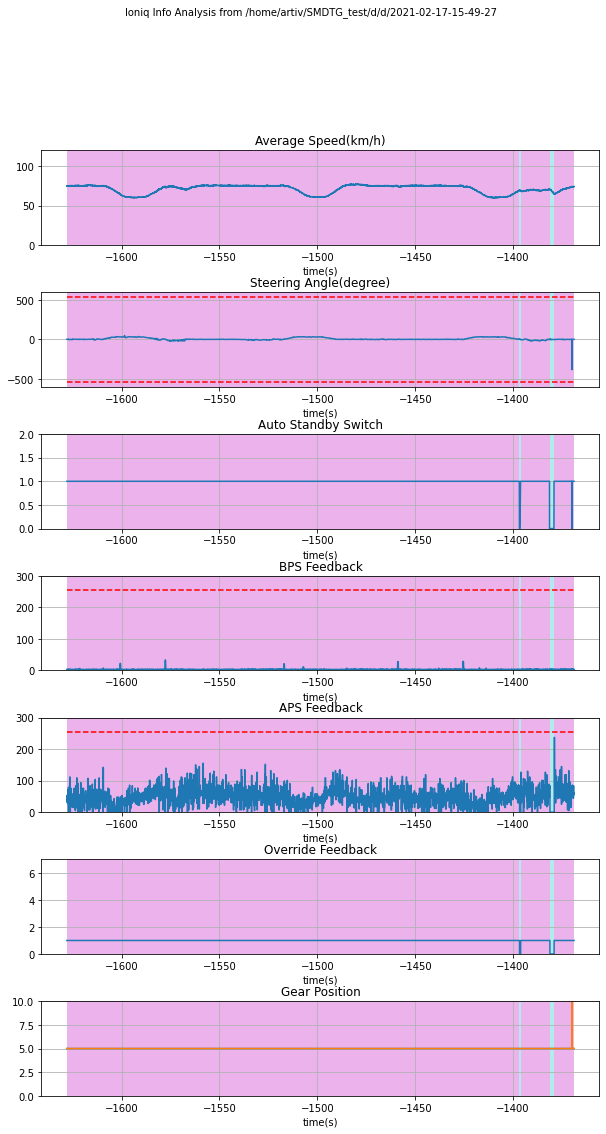

total:  5072.638999999985 m
manaul:  51.591000000000015 m
/home/artiv/SMDTG_test/d/d/2021-02-17-15-26-40.bag
[INFO]  Successfully created the data folder /home/artiv/SMDTG_test/d/d/2021-02-17-15-26-40.
File saved: /home/artiv/SMDTG_test/d/d/2021-02-17-15-26-40/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
File saved: /home/artiv/SMDTG_test/d/d/2021-02-17-15-26-40/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
Calcultation Full Info Done!!!
total number  of graph:  7


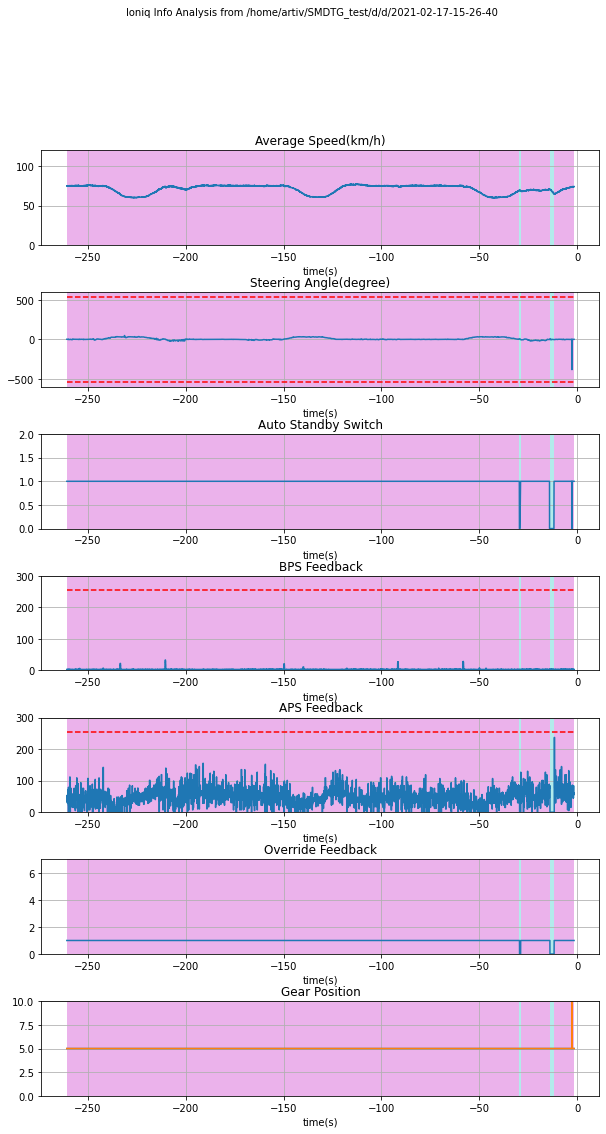

total:  5072.646999999983 m
manaul:  51.591000000000015 m
/home/artiv/SMDTG_test/d/d/2021-02-17-16-16-35.bag
[INFO]  Successfully created the data folder /home/artiv/SMDTG_test/d/d/2021-02-17-16-16-35.
File saved: /home/artiv/SMDTG_test/d/d/2021-02-17-16-16-35/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
File saved: /home/artiv/SMDTG_test/d/d/2021-02-17-16-16-35/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
Calcultation Full Info Done!!!
total number  of graph:  7


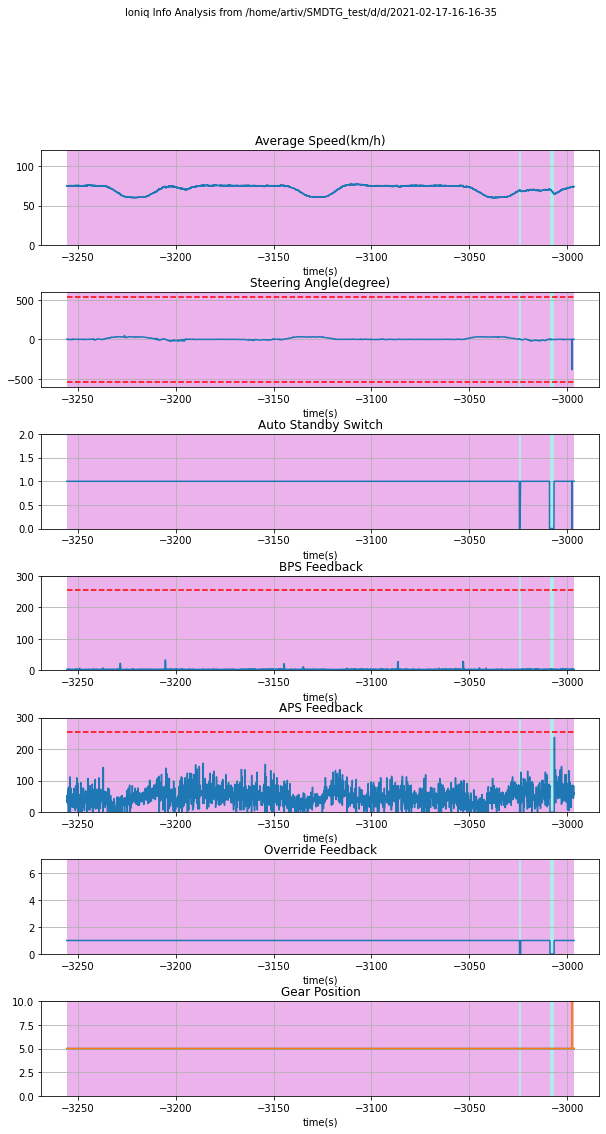

total:  5072.636999999985 m
manaul:  51.591000000000015 m
/home/artiv/SMDTG_test/d/d/2021-02-17-16-35-53.bag
[INFO]  Successfully created the data folder /home/artiv/SMDTG_test/d/d/2021-02-17-16-35-53.
File saved: /home/artiv/SMDTG_test/d/d/2021-02-17-16-35-53/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
File saved: /home/artiv/SMDTG_test/d/d/2021-02-17-16-35-53/Ioniq_info.csv
Preprocessing is Successfully Done!!!!!
Calcultation Full Info Done!!!
total number  of graph:  7


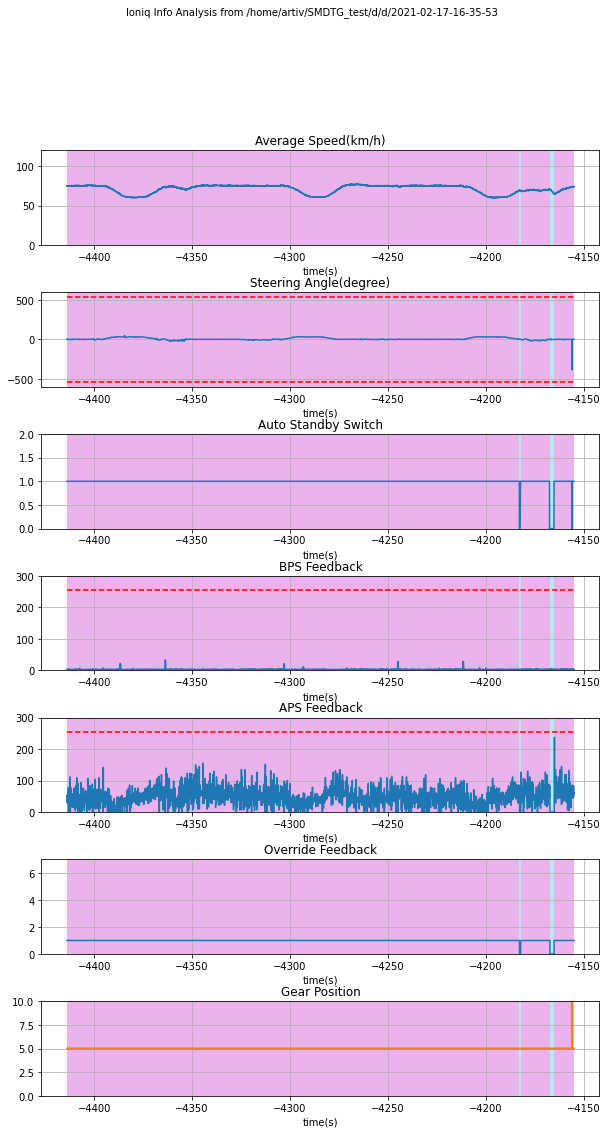

total:  5072.633999999983 m
manaul:  51.591000000000015 m
/home/artiv/SMDTG_test/d/d/2021-01-22-17-22-19_pure.bag


In [ ]:
if __name__=="__main__":
    auto = 0
    manual = 0
    
    dirname = os.getcwd()
    SCC_files = []
    for dirpath, subdirs, files in os.walk(dirname):
        for x in files:
            if x.endswith(".bag"):
                print(os.path.join(dirpath, x))
                filename = os.path.join(dirpath, x)[:-4]
                try:
                    IoniqInfo = BagParser(filename)
                    IoniqInfo.get_data()
                    IoniqInfo.calc_full_info()
                    IoniqInfo.save_full_info()
                    IoniqInfo.visualize() 
                    print("total: ", IoniqInfo.resultData.total_auto_driving_distance, "m")
                    print("manaul: ", IoniqInfo.resultData.total_manual_driving_distance, "m")
                    auto += IoniqInfo.resultData.total_auto_driving_distance
                    manual += IoniqInfo.resultData.total_manual_driving_distance
                except:
                    print(filename)
                    SCC_files.append(filename)
                    
    with open("total_info.txt", "w") as f:
        f.write("auto: ", auto, "m")
        f.write("manaul: ", manual, "m")
        f.write("total: ", auto+manual, "m")
        f.write(SCC_files)
    
    """
    # for all bag file in dir
    myPath = os.getcwd()
    myExt = '*.bag'
    rosbag = glob.glob(os.path.join(myExt))
    print("rosbag", rosbag)
    for bagfile in rosbag:
        bagfile_name = bagfile[:-4]        
        #bagfile_name = '2021-01-22-17-15-33_max braking'
        IoniqInfo = BagParser(bagfile_name)
        #IoniqInfo.summary()
        IoniqInfo.get_data()
        IoniqInfo.calc_full_info()
        IoniqInfo.save_full_info()
        IoniqInfo.visualize() 
    """
    """   
    # for one bag file
    bagfile_name = '2021-02-17-18-20-57'
    IoniqInfo = BagParser(bagfile_name)
    #IoniqInfo.summary()
    IoniqInfo.get_data()
    IoniqInfo.calc_full_info()
    IoniqInfo.save_full_info()
    IoniqInfo.visualize()   
    """